In [1]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
import os

In [3]:
data_dir = 'data'

In [5]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [6]:
image_exts = ['jpeg','jpg','bmp','png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [9]:
import numpy as np

In [26]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 997 files belonging to 3 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()
#get another batch from the iterator

In [13]:
batch[0].shape
#image represented as numpy arrays

(32, 256, 256, 3)

In [14]:
batch[1]
#class 0 = earthquakes
#class 1 = landslides
#class 2 = wildfire

array([2, 1, 1, 0, 1, 0, 2, 0, 1, 2, 0, 2, 2, 2, 1, 2, 0, 2, 1, 0, 2, 2,
       0, 1, 2, 1, 1, 2, 0, 2, 1, 1])

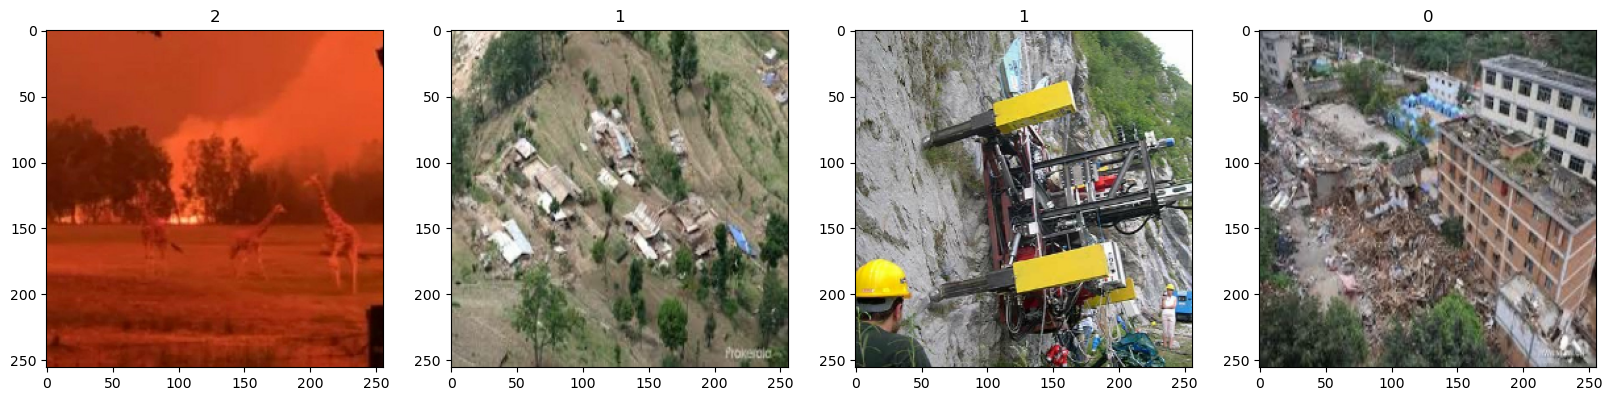

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
len(data)

32

In [20]:
train_size = int(len(data)*.7) #to train our deep learning model
val_size = int(len(data)*.2) #evaluate our data while we're training
test_size = int(len(data)*.1) 

In [21]:
# take defines how much data we are going take in that particular partition
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [27]:
#to import some sequential apis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [28]:
model = Sequential()

In [29]:
#1st line adding maxpooling layer and convolutional layer
model.add(Conv2D(16, (3,3), 1,activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1,activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [30]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,139 (14.10 MB)

 Trainable params: 3,697,139 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
logdir = 'logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.4726 - loss: 2.2025 - val_accuracy: 0.7240 - val_loss: 0.6684
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.7068 - loss: 0.6265 - val_accuracy: 0.8385 - val_loss: 0.5326
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - accuracy: 0.7892 - loss: 0.5247 - val_accuracy: 0.8854 - val_loss: 0.4012
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.8424 - loss: 0.3901 - val_accuracy: 0.8802 - val_loss: 0.3133
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.8368 - loss: 0.3513 - val_accuracy: 0.9271 - val_loss: 0.2146
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 394ms/step - accuracy: 0.9024 - loss: 0.2428 - val_accuracy: 0.8802 - val_loss: 0.2799
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 483ms/step - accuracy: 0.8959 - loss: 0.2820 - val_accuracy: 0.9167 - val_loss: 0.2285
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.9403 - loss: 0.1527 - val_accuracy: 

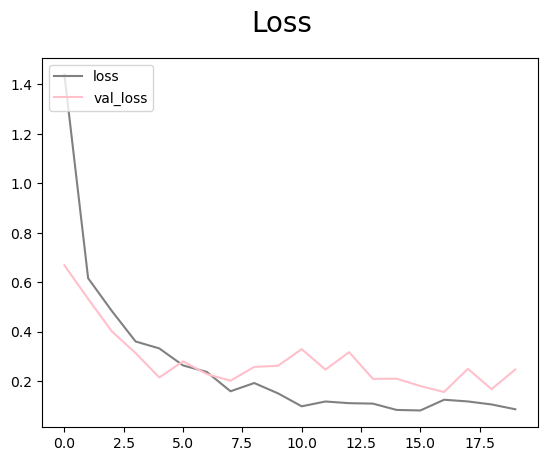

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'grey', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'pink', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

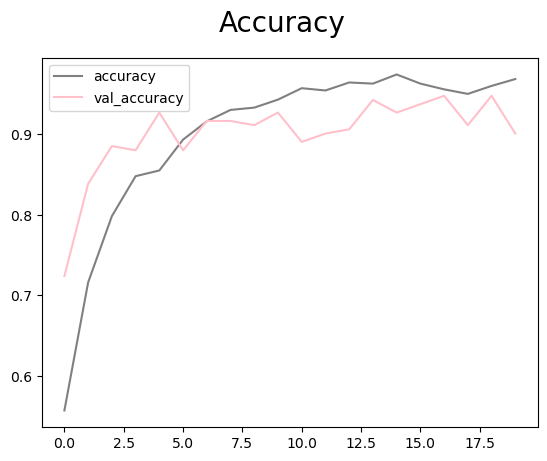

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='grey', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='pink', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [37]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [38]:
acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [51]:
print("Test Accuracy:", acc.result().numpy())

Test Accuracy: 0.96875


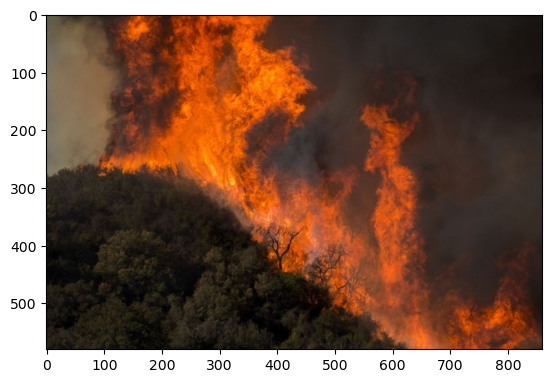

In [41]:
img = cv2.imread('wildfire_testcase.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

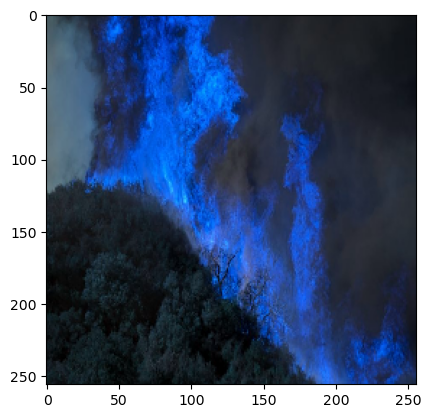

In [42]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


In [44]:
yhat

array([[5.5743178e-04, 2.2617918e-02, 9.7682470e-01]], dtype=float32)

In [45]:
predicted_class = np.argmax(yhat)

In [46]:
if predicted_class == 0: 
    print(f'Predicted class is Earthquake')
elif predicted_class == 1:
    print(f'Predicted class is Landslide')
else:
    print(f'Predicted class is Wildfire')

Predicted class is Wildfire


In [47]:
from tensorflow.keras.models import load_model

In [48]:
model.save('my_model.keras')

In [49]:
new_model = load_model('my_model.keras')

In [50]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


array([[5.5743178e-04, 2.2617918e-02, 9.7682470e-01]], dtype=float32)